### G5 Class Activation Map

- 학습 목표 
    - Classification model로부터 CAM을 얻어낼 수 있다. 
    - CAM으로 물체의 위치를 찾을 수 있다. 
    - CAM을 시각화 비교할 수 있다. 

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image
import urllib3

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    )

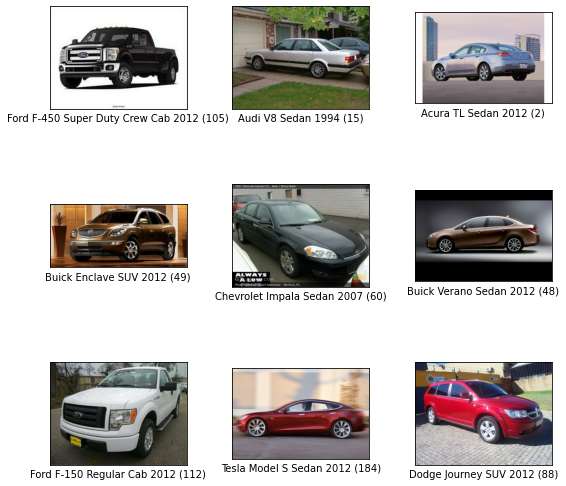

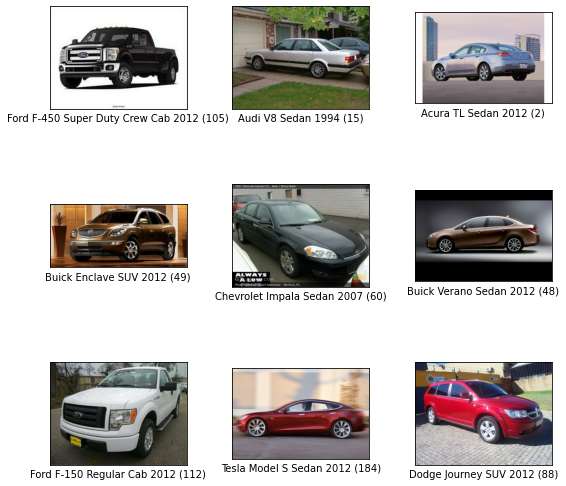

In [4]:
tfds.show_examples(ds_train, ds_info)

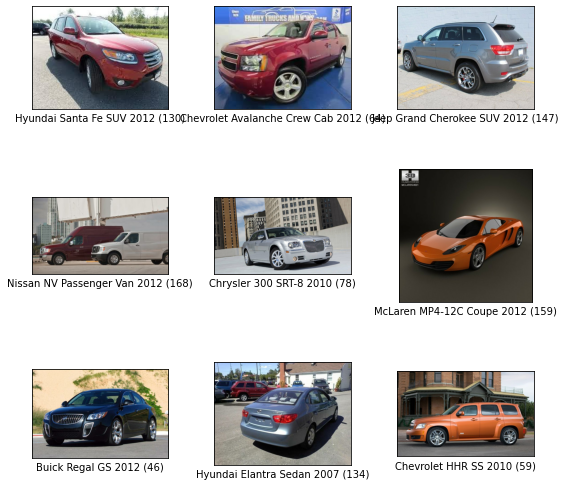

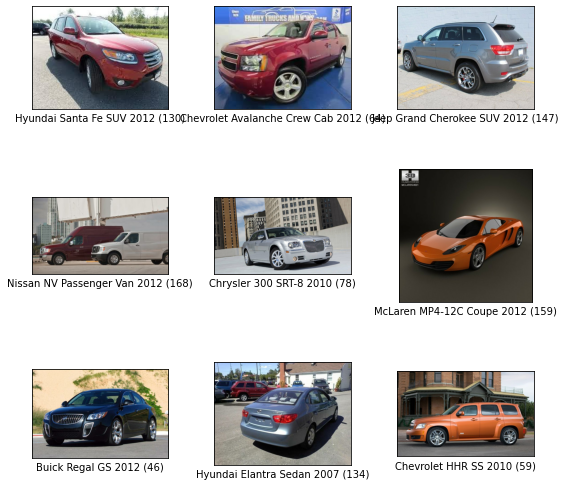

In [5]:
tfds.show_examples(ds_test, ds_info)

In [6]:
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

In [7]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet.ResNet50(
    include_top=False, 
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)

cam_model=keras.Model(inputs=base_model.input, outputs=preds)

In [8]:
cam_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [9]:
def normalize_and_resize_img(input):
    
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2,
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

In [11]:
tf.random.set_seed(2020)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [12]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15, 
    validation_data=ds_test_norm, 
    verbose=1, 
    use_multiprocessing=True,
)

Epoch 1/15
  2/509 [..............................] - ETA: 34s - loss: 5.6480 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0517s vs `on_train_batch_end` time: 0.0836s). Check your callbacks.


509/509 [==============================] - 79s 156ms/step - loss: 4.1633 - accuracy: 0.1692 - val_loss: 5.4142 - val_accuracy: 0.0077
Epoch 2/15
509/509 [==============================] - 80s 157ms/step - loss: 1.6237 - accuracy: 0.6475 - val_loss: 1.9333 - val_accuracy: 0.5025
Epoch 3/15
509/509 [==============================] - 79s 155ms/step - loss: 0.5198 - accuracy: 0.9120 - val_loss: 1.3621 - val_accuracy: 0.6477
Epoch 4/15
509/509 [==============================] - 79s 155ms/step - loss: 0.1565 - accuracy: 0.9845 - val_loss: 1.1423 - val_accuracy: 0.7003
Epoch 5/15
509/509 [==============================] - 93s 182ms/step - loss: 0.0718 - accuracy: 0.9978 - val_loss: 1.0654 - val_accuracy: 0.7165
Epoch 6/15
509/509 [==============================] - 79s 155ms/step - loss: 0.0341 - accuracy: 0.9982 - val_loss: 1.0558 - val_accuracy: 0.7257
Epoch 7/15
509/509 [==============================] - 79s 155ms/step - loss: 0.0315 - accuracy: 0.9979 - val_loss: 1.0243 - val_accuracy: 0.7

In [14]:
import os 

cam_model_path = os.getenv('HOME') + ('/aiffel/class_activation_map/cam_model.h5')
cam_model.save(cam_model_path)

In [34]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

64


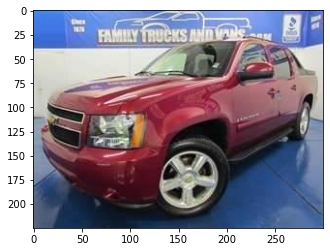

In [35]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [37]:
cam_model = tf.keras.models.load_model(cam_model_path)

In [38]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0]
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        
        cam_image += w * conv_outputs[:, :, i]
        
    cam_image /= np.max(cam_image)
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height))
    return cam_image

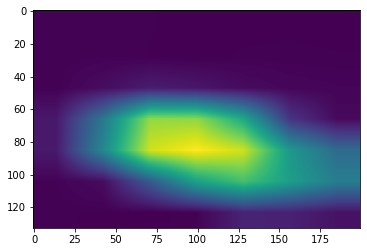

In [39]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [40]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

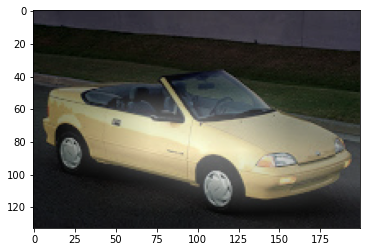

In [41]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

189


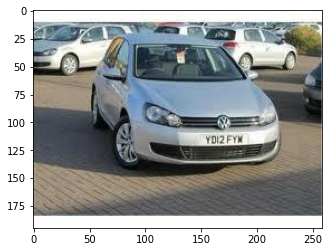

In [42]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [ ]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    